In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import MeanShift, estimate_bandwidth

# evaluation
from sklearn.metrics.cluster import silhouette_score
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.metrics import *

plt.style.use('seaborn')
sns.set_palette("hls")
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
%cd /content/drive/My Drive/Colab Notebooks/bdproj

/content/drive/My Drive/Colab Notebooks/bdproj


# Preprocessing

As the data has been crawled by myself, I thought it was most important to guarantee the quality of datasets through preprocessing such as dimensionality reduction and data transformation to fit clustering.

In [0]:
movie_df = pd.read_csv('data.csv')

The crawled data is as follows.

In [5]:
movie_df.head()

,Unnamed: 0,year,title,release_year,release_month,nation,genre,netizen_grade,rating,total_audience
0,36635,2004,태극기 휘날리며,2004,2,한국,전쟁,9.1,15세관람가,"11,746,135"
1,37066,2004,트로이,2004,5,"미국, 몰타, 영국",액션/로맨스/멜로,8.4,15세관람가,"2,001,318"
2,39368,2004,내 머리 속의 지우개,2004,11,한국,로맨스/멜로/드라마,8.7,12세관람가,"1,887,868"
3,39411,2004,귀신이 산다,2004,9,한국,코미디/판타지/공포,6.4,12세관람가,"1,875,936"
4,38807,2004,투모로우,2004,6,미국,액션/스릴러/SF/어드벤처/드라마,8.2,12세관람가,"1,830,767"


### Information of the data

In [6]:
# I corrected the column title of movie id because it was wrong.
# The overall information of the data is as follows. It has 850 entries and each column is as follows.
movie_df.rename(columns={"Unnamed: 0": 'movie_id'}, inplace=True)
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 850 entries, 0 to 849
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   movie_id        850 non-null    int64  
 1   year            850 non-null    int64  
 2   title           850 non-null    object 
 3   release_year    850 non-null    int64  
 4   release_month   850 non-null    int64  
 5   nation          850 non-null    object 
 6   genre           850 non-null    object 
 7   netizen_grade   850 non-null    float64
 8   rating          850 non-null    object 
 9   total_audience  850 non-null    object 
dtypes: float64(1), int64(4), object(5)
memory usage: 66.5+ KB


### Processing of missing values

In [7]:
# Check if any column has null value -> No null value
movie_df.isnull().sum(axis=0)

movie_id          0
year              0
title             0
release_year      0
release_month     0
nation            0
genre             0
netizen_grade     0
rating            0
total_audience    0
dtype: int64

### Processing duplicate value
Since the crawling data is based on Korea annual box office rankings, duplicated values exist when the same film was included in the rankings over the years. Thus I checked it based on the movie_id given to each film by DAUM website, and then deleted one of them.

In [8]:
# Check the duplicated entries
movie_df[movie_df.duplicated(['movie_id'], keep=False)]

,movie_id,year,title,release_year,release_month,nation,genre,netizen_grade,rating,total_audience
6,35497,2004,해리포터와 아즈카반의 죄수,2004,7,"영국, 미국",판타지/어드벤처,8.4,전체관람가,"1,833,382"
24,39208,2004,하울의 움직이는 성,2004,12,일본,애니메이션/판타지/로맨스/멜로,9.0,전체관람가,"2,614,043"
63,39432,2005,킹콩,2005,12,"뉴질랜드, 미국",액션/판타지/어드벤처,8.7,15세관람가,"3,470,059"
71,39208,2005,하울의 움직이는 성,2004,12,일본,애니메이션/판타지/로맨스/멜로,9.0,전체관람가,"2,614,043"
107,40440,2006,미녀는 괴로워,2006,12,한국,코미디,8.9,12세이상관람가,"6,081,480"
111,42152,2006,박물관이 살아있다!,2006,12,"미국, 영국",코미디/어드벤처,8.2,전체관람가,"4,245,247"
129,39432,2006,킹콩,2005,12,"뉴질랜드, 미국",액션/판타지/어드벤처,8.7,15세관람가,"3,470,059"
160,40440,2007,미녀는 괴로워,2006,12,한국,코미디,8.9,12세이상관람가,"6,081,480"
171,42152,2007,박물관이 살아있다!,2006,12,"미국, 영국",코미디/어드벤처,8.2,전체관람가,"4,245,247"
204,48057,2008,과속스캔들,2008,12,한국,코미디/드라마,9.3,12세이상관람가,"8,223,342"


In [0]:
movie_df = movie_df.drop_duplicates('movie_id')

### Deleting unmeaningful columns
The feature "year" which means the year included in the box office rankings, and "release_year" meaning the year when the movie was released, are mostly redundant, so the feature "year" is deleted.

In [0]:
# del movie_df['movie_id']
del movie_df['year']
movie_df.index = list(range(0,822)) # Re-indexing

### Correcting the format, reducing dimensionality by combining features, **One-hot encoding** each column

#### **'Nation'**

In [0]:
# Split each string with ',' and strip
movie_df.nation = movie_df.nation.str.split(',')
movie_df.nation = [[val.strip() for val in each] for each in movie_df.nation.values]

In [12]:
# The number of times each country appears in "nation" which means the country where the film was produced, is as follows. 
# This is the result of allowing duplication because one film is sometimes made in several countries.
pd.Series(x for l in movie_df.nation.tolist() for x in l).value_counts()

한국          448
미국          346
영국           57
중국           17
독일           17
프랑스          16
오스트레일리아      10
일본            8
캐나다           8
뉴질랜드          6
홍콩            6
스페인           4
벨기에           3
체코            2
몰타            2
아일랜드          2
대만            2
아메리칸사모아       1
러시아           1
인도            1
아르헨티나         1
네덜란드          1
이탈리아          1
헝가리           1
남아프리카공화국      1
dtype: int64

In [0]:
# The countries are grouped into meaningful groups based on continents, etc.
# One-hot encoded based on these groups and delete initial column 'nation'
group1 = ['미국', '캐나다'] # US/Canada
group2 = ['독일', '러시아', '몰타', '벨기에', '스페인', '아일랜드','네덜란드', '이탈리아', '체코', '프랑스', '헝가리', '영국'] # Europe
group3 = ['한국'] # Korea
group4 = ['대만', '인도', '일본', '중국', '홍콩'] #Asia
group5 = ['남아프리카공화국', '아르헨티나', '아메리칸사모아', '뉴질랜드', '오스트레일리아'] #Etc

tmp = movie_df.nation.str.join('|').str.get_dummies()
movie_df['US_CA'] = (tmp[group1].sum(axis = 1) > 0).astype(int)
movie_df['EUR'] = (tmp[group2].sum(axis = 1) > 0).astype(int)
movie_df['KOR'] = (tmp[group3].sum(axis = 1) > 0).astype(int)
movie_df['ASIA'] = (tmp[group4].sum(axis = 1) > 0).astype(int)
movie_df['ETC'] = (tmp[group5].sum(axis = 1) > 0).astype(int)
del movie_df['nation']

#### **'genre'**

In [0]:
# Column genre: split each string with '/' and strip
movie_df.genre = movie_df.genre.str.split('/')
movie_df.genre = [[val.strip() for val in each] for each in movie_df.genre.values]

In [15]:
# The number of times each genre appears in column "genre" is as follows. 
# This is the result of allowing duplication because one film categorized into multiple genres.
pd.Series(x for l in movie_df.genre.tolist() for x in l).value_counts()

액션       305
드라마      251
코미디      188
어드벤처     154
스릴러      127
로맨스       96
멜로        96
SF        88
범죄        86
판타지       76
애니메이션     65
가족        37
미스터리      32
공포        27
시대극       24
전쟁        21
뮤지컬       12
다큐멘터리      3
무협         1
서부         1
dtype: int64

In [0]:
# The genres are grouped into meaningful groups.
# One-hot encoded based on these groups and delete initial column 'genre'

group1 = ['로맨스', '멜로']
group2 = ['코미디']
group3 = ['드라마', '가족']
group4 = ['무협', '전쟁', '액션', '범죄', '서부']
group5 = ['SF', '판타지', '어드벤처']
group6 = ['시대극']
group7 = ['애니메이션']
group8 = ['미스터리', '공포', '스릴러']

tmp = movie_df.genre.str.join('|').str.get_dummies()
movie_df['Romance'] = (tmp[group1].sum(axis = 1) > 0).astype(int)
movie_df['Comedy'] = (tmp[group2].sum(axis = 1) > 0).astype(int)
movie_df['Drama'] = (tmp[group3].sum(axis = 1) > 0).astype(int)
movie_df['Action'] = (tmp[group4].sum(axis = 1) > 0).astype(int)
movie_df['Adventure'] = (tmp[group5].sum(axis = 1) > 0).astype(int)
movie_df['Historical'] = (tmp[group6].sum(axis = 1) > 0).astype(int)
movie_df['Animation'] = (tmp[group7].sum(axis = 1) > 0).astype(int)
movie_df['Thriller'] = (tmp[group8].sum(axis = 1) > 0).astype(int)
del movie_df['genre']

#### **'rating'**

In [17]:
# Some words such as '15세관람가' and '15세이상관람가' which have same meaning are in different wordings.
movie_df.rating.unique()

array(['15세관람가', '12세관람가', '전체관람가', '12세이상관람가', '18세관람가', '15세이상관람가',
       '청소년관람불가'], dtype=object)

In [0]:
# Different screening ratings are replaced by the same term, unified and one-hot encoded
movie_df.rating = movie_df.rating.replace({'전체관람가':'rating_all', '12세관람가':'rating_12', '12세이상관람가':'rating_12','15세관람가':'rating_15', '15세이상관람가':'rating_15', '18세관람가':'rating_adult', '청소년관람불가':'rating_adult'})
movie_df = movie_df.drop('rating', 1).join(movie_df.rating.str.get_dummies())

#### **'release_month'**

In [0]:
# The season when the movie is released can be interpreted somewhat meaningfully, for example, the number of audiences increasing in summer. 
# Therefore, the data classified by month were grouped into more broad ranges, quarters (seasonals).
movie_df.quarter = movie_df.release_month.replace({1:'Q1', 2:'Q1', 3:'Q1',4:'Q2', 5:'Q2', 6:'Q2', 7:'Q3', 8:'Q3', 9:'Q3', 10:'Q4', 11:'Q4', 12:'Q4'})
movie_df = movie_df.drop('release_month', 1).join(movie_df.quarter.str.get_dummies())

#### 'total_audience'

In [0]:
# Make 'total_audience' object to integer
movie_df.total_audience = movie_df.total_audience.replace(',', '', regex=True).astype(int)

#### **'release_year'**

In [0]:
movie_df = movie_df.drop('release_year', 1).join(movie_df.release_year.astype(str).str.get_dummies())

### Data after preprocessing is as follows

In [22]:
movie_df.head()

,movie_id,title,netizen_grade,total_audience,US_CA,EUR,KOR,ASIA,ETC,Romance,Comedy,Drama,Action,Adventure,Historical,Animation,Thriller,rating_12,rating_15,rating_adult,rating_all,Q1,Q2,Q3,Q4,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,36635,태극기 휘날리며,9.1,11746135,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,37066,트로이,8.4,2001318,1,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,39368,내 머리 속의 지우개,8.7,1887868,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,39411,귀신이 산다,6.4,1875936,0,0,1,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,38807,투모로우,8.2,1830767,1,0,0,0,0,0,0,1,1,1,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [23]:
df = movie_df.copy()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 822 entries, 0 to 821
Data columns (total 43 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   movie_id        822 non-null    int64  
 1   title           822 non-null    object 
 2   netizen_grade   822 non-null    float64
 3   total_audience  822 non-null    int64  
 4   US_CA           822 non-null    int64  
 5   EUR             822 non-null    int64  
 6   KOR             822 non-null    int64  
 7   ASIA            822 non-null    int64  
 8   ETC             822 non-null    int64  
 9   Romance         822 non-null    int64  
 10  Comedy          822 non-null    int64  
 11  Drama           822 non-null    int64  
 12  Action          822 non-null    int64  
 13  Adventure       822 non-null    int64  
 14  Historical      822 non-null    int64  
 15  Animation       822 non-null    int64  
 16  Thriller        822 non-null    int64  
 17  rating_12       822 non-null    int

# Transformation

- Since most statistical analysis methods are based on the normal distributed data, it is important to convert data to be normal distributed as much as possible, even if it is not perfect. For example, if the data have a value of zero, such as typical log data, or if have extremely positive skewed distributions, or if the distribution is heavily biased, the data can be converted to log, sqrt, box-cox, and so on.

- There are two numerical columns 'total_audience' and 'netizen_grade'.

In [24]:
# The movie has a high rating because the data is based on the highest ranking in the box office.
df['netizen_grade'].describe()

count    822.000000
mean       7.553285
std        1.015103
min        2.900000
25%        6.900000
50%        7.600000
75%        8.300000
max        9.700000
Name: netizen_grade, dtype: float64

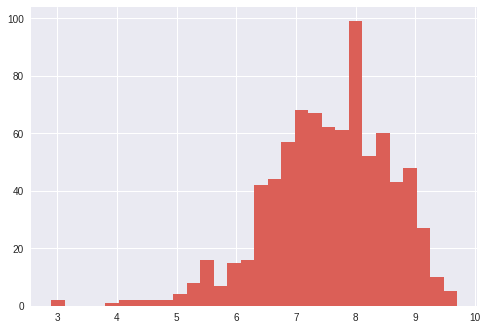

In [25]:
df['netizen_grade'].hist(bins=30)
plt.show()

In [26]:
# It is slightly out of the boundary(-0.5~0.5) which is usually considered as the approximately symmetric boundary.
df['netizen_grade'].skew() 

-0.6826412325875132

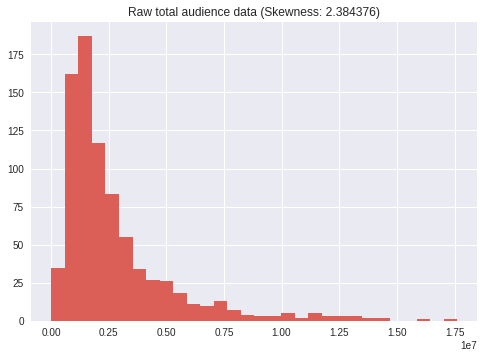

In [27]:
# Total audience: extremely positive skewed distribution
# The skewness of total_audience is way higher than the normal distributions and the plot is seemed in that way.
df['total_audience'].hist(bins=30)
plt.title('Raw total audience data (Skewness: %f)'%df.total_audience.skew())
plt.show()

In [28]:
df.total_audience.describe()

count    8.220000e+02
mean     2.761059e+06
std      2.537796e+06
min      1.758800e+04
25%      1.208573e+06
50%      1.881834e+06
75%      3.268014e+06
max      1.761568e+07
Name: total_audience, dtype: float64

Log transformation

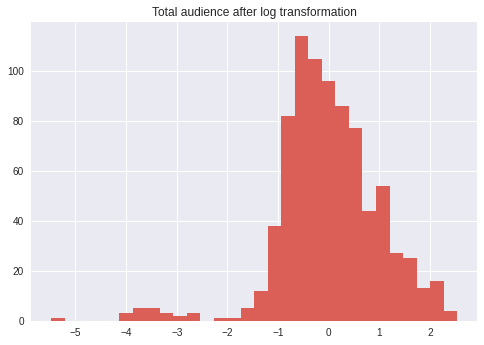

In [29]:
from sklearn import preprocessing

# Total_audience: Log transformed
df['total_audience_log'] = preprocessing.scale(np.log(df['total_audience']+1))
df['total_audience_log'].hist(bins=30) # Less skewed than before
plt.title('Total audience after log transformation')
plt.show()

### Scaling: StandardScaler

- Since clustering such as K-means and DBSCAN is a **distance-based algorithm**, data has been standardized to eliminate the effects of the scale.


In [0]:
standard_scaler = StandardScaler()
scale_df = df.copy()

# Scaling log transformed audience and netizen grade
col_names = ['total_audience_log', 'netizen_grade']
features = scale_df[col_names]
scaler = standard_scaler.fit(features.values)
features = scaler.transform(features.values)
scale_df[col_names] = features

In [31]:
scale_df.head()

,movie_id,title,netizen_grade,total_audience,US_CA,EUR,KOR,ASIA,ETC,Romance,Comedy,Drama,Action,Adventure,Historical,Animation,Thriller,rating_12,rating_15,rating_adult,rating_all,Q1,Q2,Q3,Q4,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,total_audience_log
0,36635,태극기 휘날리며,1.524631,11746135,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.066012
1,37066,트로이,0.834626,2001318,1,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.013778
2,39368,내 머리 속의 지우개,1.130342,1887868,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.053895
3,39411,귀신이 산다,-1.136818,1875936,0,0,1,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.061248
4,38807,투모로우,0.637481,1830767,1,0,0,0,0,0,0,1,1,1,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.089512


In [32]:
scale_df.total_audience.describe()

count    8.220000e+02
mean     2.761059e+06
std      2.537796e+06
min      1.758800e+04
25%      1.208573e+06
50%      1.881834e+06
75%      3.268014e+06
max      1.761568e+07
Name: total_audience, dtype: float64

In [33]:
scale_df.total_audience_log.describe()

count    8.220000e+02
mean     7.239410e-17
std      1.000609e+00
min     -5.476287e+00
25%     -5.711031e-01
50%     -5.761323e-02
75%      5.824326e-01
max      2.535974e+00
Name: total_audience_log, dtype: float64

In [34]:
df.netizen_grade.describe()

count    822.000000
mean       7.553285
std        1.015103
min        2.900000
25%        6.900000
50%        7.600000
75%        8.300000
max        9.700000
Name: netizen_grade, dtype: float64

In [0]:
del scale_df['total_audience']
del scale_df['title']
del scale_df['movie_id']

del df['total_audience']
del df['title']
del df['movie_id']

In [36]:
scale_df.head()

,netizen_grade,US_CA,EUR,KOR,ASIA,ETC,Romance,Comedy,Drama,Action,Adventure,Historical,Animation,Thriller,rating_12,rating_15,rating_adult,rating_all,Q1,Q2,Q3,Q4,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,total_audience_log
0,1.524631,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.066012
1,0.834626,1,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.013778
2,1.130342,0,0,1,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.053895
3,-1.136818,0,0,1,0,0,0,1,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.061248
4,0.637481,1,0,0,0,0,0,0,1,1,1,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-0.089512


# PCA

Overall, there are **39** features so far even though several columns are combined such as 'month', 'genre'. As there are more features compared to the number of data, dimensions of the data must be reduced. For solving multicollinearity problems and increasing the efficiency of analysis, and expressing clustering results in two dimensions, dimensionality reduction is needed.

In this project, I implemented PCA(Principal Component Analysis). PCA is defined as the orthogonal projection of the data onto a lower dimensonal linear space known as the principal subspace, such that the variance of the projected data is maximized. 

In other words, PCA aims to reduce the number of features as much as possible (ideally two to three components) while ensuring maximum explanatory power of the features.

In [37]:
# In order to visualize it on a flat surface, dimensions reduced to two dimensions using PCA.
pca = PCA(n_components=2)
reduced_scale_df = pca.fit_transform(scale_df)
reduced_scale_df.shape

(822, 2)

In [38]:
# I decided to look further into our first component to see which variables were most important to the first component.
# Total audience and netizen grade which are numerical values seem to be most important
# Other variables that come up such as Drama, Q1 and 2020 are interesting.
# This aligns with our understanding that most top rated movies are in fact Drama movie.
first_comp = pca.components_[0]
first_comps = pd.DataFrame(zip(first_comp, scale_df.columns), columns=['weights', 'features'])
first_comps['abs_weights'] = first_comps['weights'].apply(lambda x: np.abs(x))
first_comps.sort_values('abs_weights', ascending=False)

,weights,features,abs_weights
40,-0.711234,total_audience_log,0.711234
0,-0.677107,netizen_grade,0.677107
8,-0.078238,Drama,0.078238
39,0.075098,2020,0.075098
18,0.057158,Q1,0.057158
14,-0.054426,rating_12,0.054426
15,0.053945,rating_15,0.053945
13,0.053118,Thriller,0.053118
20,-0.048468,Q3,0.048468
7,0.046152,Comedy,0.046152


# Modeling

Implented clustering, which is unsupervised learning.

Minimizing the intra-cluster variance and maximize the inter-cluster variance

Where are clustering used
- Understanding the data
- Summarization and visualization
- Strategy planning


Clustering validity measure: Silhouette coefficient
- a(i): average distance between an instance i and the other instances in the same cluster
- b(i): the minimum of the average distances between an instance i and the instances is a cluster to which the instance i does not belong

s(i) = b(i) - a(i) / max(a(i), b(i))

- Silhouette Coefficient는 실루엣 계수로 -1 부터 1사이의 값을 가지며 1에 가까울 수록 최적화된 군집


Clustering algorithms divided into
- Partioning based: K-means (divide data into non-overlapping subsets such that each data object is in exactly one subset)
- Hierarchical based: a set of nested clusters organized as a hierarchical tree

## 1 Hierarchical Agglomerative clustering

Hierarchical clustering produces a set of nested clusters organized as a hierarchical tree. 

Strengths
- Do not have to assume any particular number of clusters. Any desired number of clusters can be obtained by cutting the dendrogram at the proper level

Two main types
1. **Agglomerative clustering**
2. Divisive clustering

There are some ways to do hierarchical clustering in terms of measures of calculating distance or measures of distance between clusters.

1. 객체 사이의 거리 측정 방식 
- L1 norm (manhattan distance)
- L2 norm (euclidean distance)
- mahalanobis (feature간의 covariance matrix 고려)
- corr distance (상관계수 높을수록 거리 짧게)

2. **Computation of the proximity of two clusters**
- single linkage (Minimum distance between two data points in different clusters)
- complete linkage (Maximum distance between two data points in different clusters)
- average linkage (Mean distance between two data points in different clusters)
- centroid linkage (Distance between centroids in different clusters)
- ward linkage (Compare the SSE before and after the merge) 


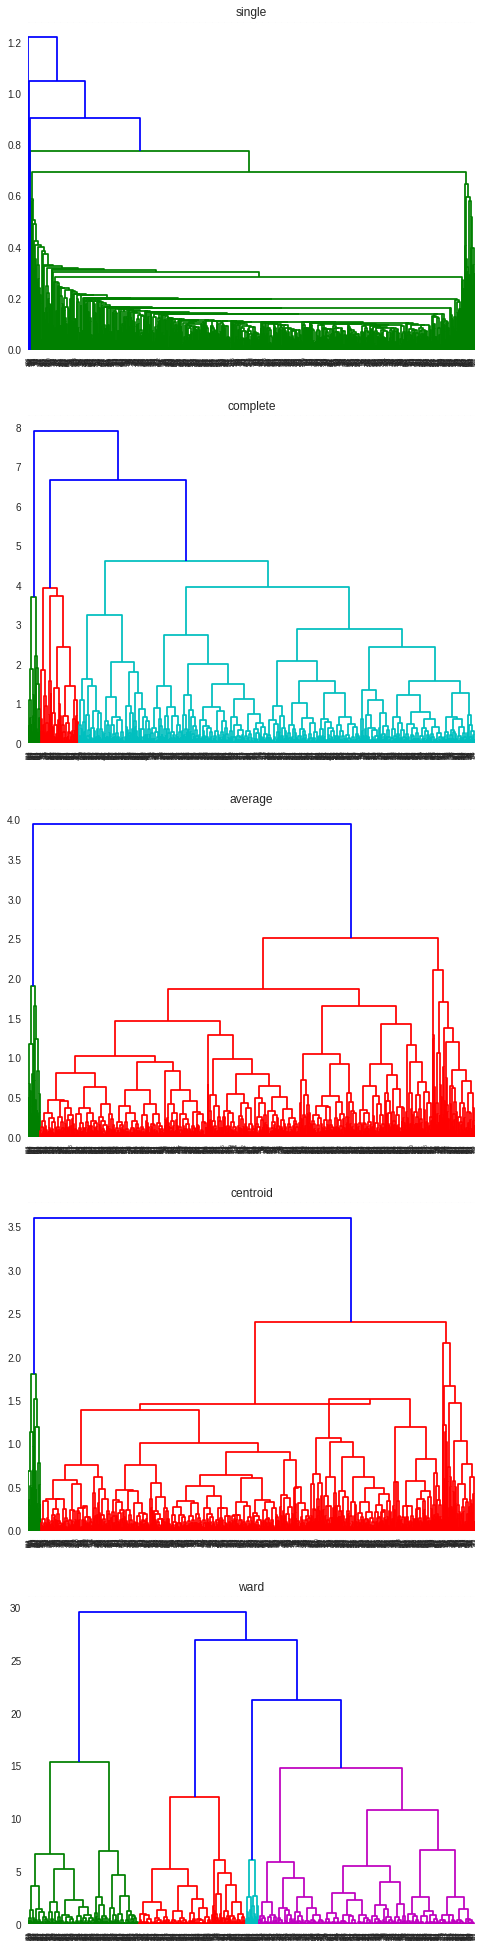

In [39]:
# There are some ways of computation of the proximity of two clusters. 
# I experimented which measures work best for this data (single linkage, complete linkage, average linkage, centroid linkage, ward linkage)
# Depending on the measures of distance between two clusters, clusering results also differ.
# Among them, 'complete linkage' and 'ward linkage' works well. 
# The distance between clusters are larger when using ward linkage(Which comparing the sum of squared error before and after the merge)

linkage_list = ['single', 'complete', 'average', 'centroid', 'ward']
data = [reduced_scale_df]

fig, axes = plt.subplots(nrows=len(linkage_list), ncols=1, figsize=(8, 35))
for i in range(len(linkage_list)):
    hierarchical_single = linkage(reduced_scale_df, method=linkage_list[i])
    dn = dendrogram(hierarchical_single, ax=axes[i])
    axes[i].title.set_text(linkage_list[i])
plt.show()

# Single linkage: seems to be not working well in clustering and the distance between clusters are so small.
# Complete link method (Max method) at 3 or 4 clusters/Ward method at 4 clusters: The data looks well clustered.
# Ward method: The distance among clusters may be relatively huge among all methods.

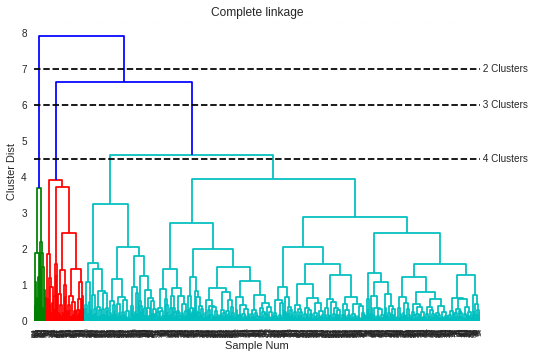

In [40]:
# Among the results of the dendrogram above, the 'complete' method seemed to be relatively well clustered, 
# so the lines separating the clusters were displayed and printed again.

dendrogram(linkage(reduced_scale_df, method='complete'))
plt.xlabel("Sample Num")
plt.ylabel("Cluster Dist")

# 클러스터를 구분하는 커트라인을 표시
ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [7, 7], '--', c='k')
ax.plot(bounds, [6, 6], '--', c='k')
ax.plot(bounds, [4.5, 4.5], '--', c='k')
ax.text(bounds[1], 7, ' 2 Clusters ', va='center', fontdict={'size': 10})
ax.text(bounds[1], 6, ' 3 Clusters ', va='center', fontdict={'size': 10})
ax.text(bounds[1], 4.5, ' 4 Clusters ', va='center', fontdict={'size': 10})
plt.title('Complete linkage')
plt.show()

# Also, if there are more than four clusters, the distance between the clusters decreases sharply.
# It seems appropriate to cut into four clusters.

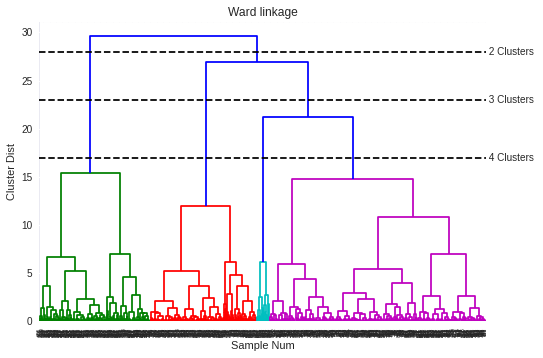

In [41]:
# Also, the 'ward' method seemed to be relatively well clustered the most, 
# so the lines separating the clusters were displayed and printed again.

dendrogram(linkage(reduced_scale_df, method='ward'))
plt.xlabel("Sample Num")
plt.ylabel("Cluster Dist")

# 클러스터를 구분하는 커트라인을 표시
ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [28, 28], '--', c='k')
ax.plot(bounds, [23, 23], '--', c='k')
ax.plot(bounds, [17, 17], '--', c='k')
ax.text(bounds[1], 28, ' 2 Clusters ', va='center', fontdict={'size': 10})
ax.text(bounds[1], 23, ' 3 Clusters ', va='center', fontdict={'size': 10})
ax.text(bounds[1], 17, ' 4 Clusters ', va='center', fontdict={'size': 10})
plt.title('Ward linkage')
plt.show()

# Also, if there are more than four clusters, the distance between the clusters decreases sharply.
# It seems appropriate to cut into four clusters.

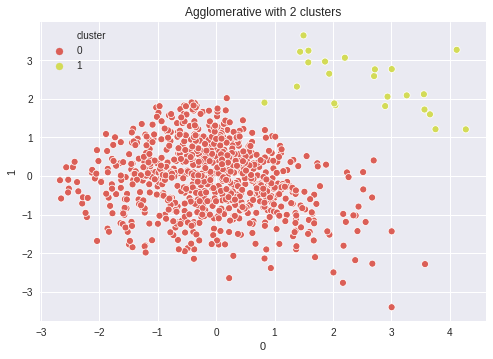

Silhouette Coefficient: 0.5643
Davies Bouldin Index: 0.6216


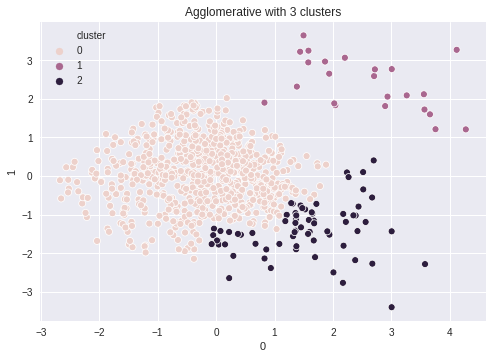

Silhouette Coefficient: 0.3831
Davies Bouldin Index: 0.7882


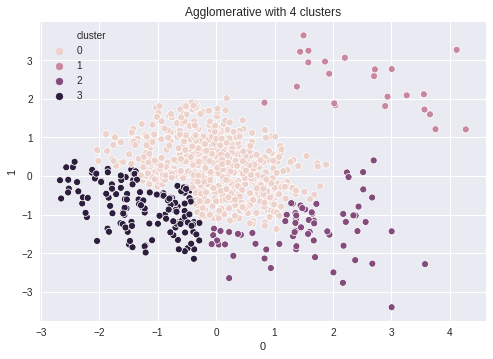

Silhouette Coefficient: 0.3027
Davies Bouldin Index: 0.8795


In [42]:
reduced_scale_df = pd.DataFrame(reduced_scale_df)

# 'complete' method: Silhouette coefficient is largest and Davies Bouldin Index is smallest when 2 clusters
# When there are 4 clusters, points which are seemed to be clustered are divided into differenc cluster, which is not a good cluster.
n = [2,3,4]
for i in n:
    agg = AgglomerativeClustering(n_clusters=i, linkage='complete')
    cluster = agg.fit(reduced_scale_df)
    cluster_id = pd.DataFrame(cluster.labels_)
    
    d4 = pd.DataFrame()
    d4 = pd.concat([reduced_scale_df,cluster_id],axis=1)
    d4.columns = [0, 1, "cluster"]
    
    sns.scatterplot(d4[0], d4[1], hue = d4['cluster'], legend="full")
    plt.title('Agglomerative with {} clusters'.format(i))
    plt.show()
    
    print('Silhouette Coefficient: {:.4f}'.format(metrics.silhouette_score(d4.iloc[:,:-1], d4['cluster'])))
    print('Davies Bouldin Index: {:.4f}'.format(metrics.davies_bouldin_score(d4.iloc[:,:-1], d4['cluster'])))

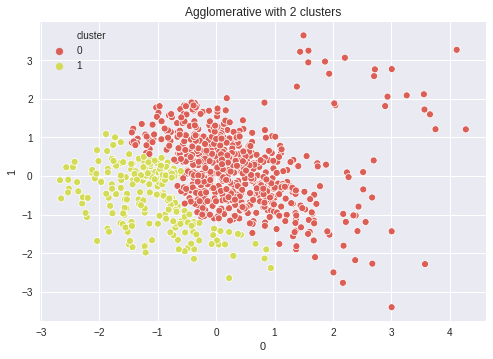

Silhouette Coefficient: 0.2885
Davies Bouldin Index: 1.1989


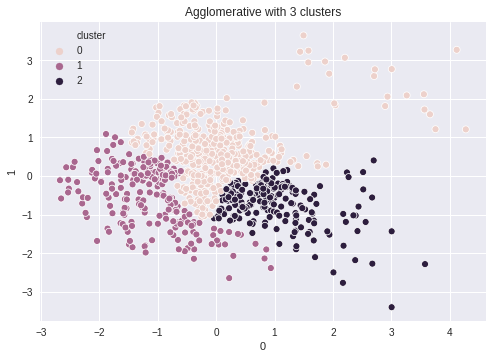

Silhouette Coefficient: 0.2969
Davies Bouldin Index: 1.0550


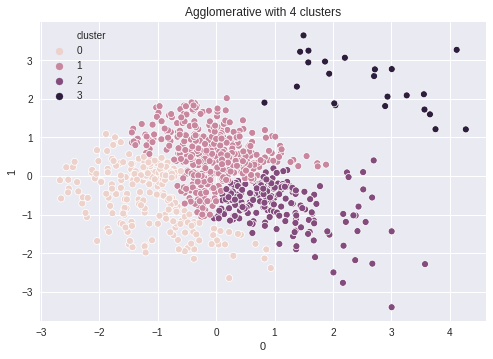

Silhouette Coefficient: 0.3270
Davies Bouldin Index: 0.9231


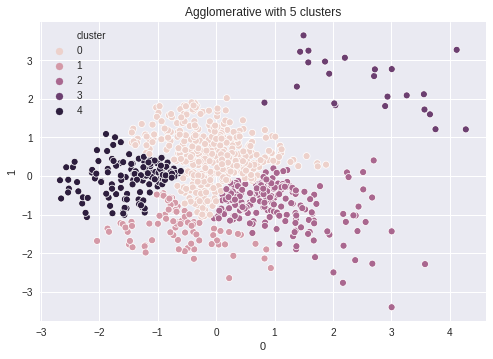

Silhouette Coefficient: 0.3105
Davies Bouldin Index: 0.8272


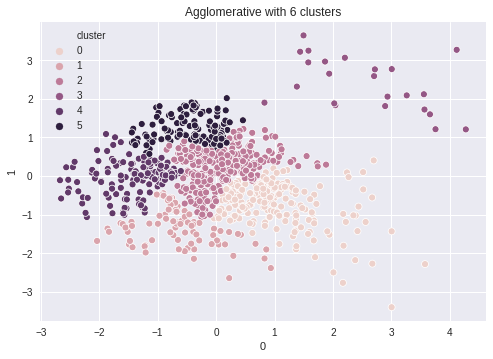

Silhouette Coefficient: 0.2891
Davies Bouldin Index: 0.8816


In [43]:
# 'ward' method: Silhouette coefficient is largest when 4 and Davies Bouldin Index is smallest when 5 clusters
# But it seemed to be not good clusters, as the close points are divided into different clusters as well.
n = [2,3,4,5,6]
for i in n:
    agg = AgglomerativeClustering(n_clusters=i, linkage='ward')
    cluster = agg.fit(reduced_scale_df)
    cluster_id = pd.DataFrame(cluster.labels_)
    
    d4 = pd.DataFrame()
    d4 = pd.concat([reduced_scale_df,cluster_id],axis=1)
    d4.columns = [0, 1, "cluster"]
    
    sns.scatterplot(d4[0], d4[1], hue = d4['cluster'], legend="full")
    plt.title('Agglomerative with {} clusters'.format(i))
    plt.show()
    
    print('Silhouette Coefficient: {:.4f}'.format(metrics.silhouette_score(d4.iloc[:,:-1], d4['cluster'])))
    print('Davies Bouldin Index: {:.4f}'.format(metrics.davies_bouldin_score(d4.iloc[:,:-1], d4['cluster'])))

### K-means
- Number of cluster K, Init centroid matter

Partional clustering approach
- Each luster is associated with a centroid.
- Each point is assigned to the cluster with the closest centroid
- Number of cluster K must be specified as a hyperparameter.



Limitations
- K-means clustering can't cope with different size. 
- cant cope with different densities. 
- cant cope with non-globular shapes

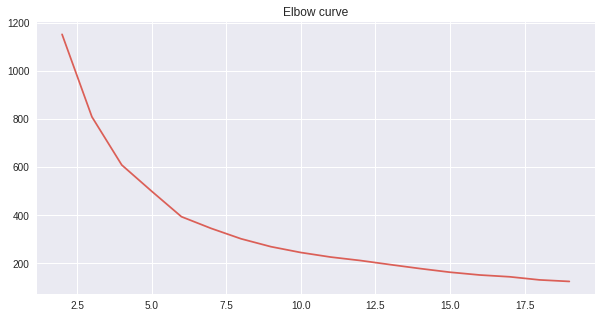

In [44]:
distortions = []
for k in range(2, 20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(reduced_scale_df)
    distortions.append(kmeans.inertia_)

fig = plt.figure(figsize=(10, 5))
plt.plot(range(2, 20), distortions)
plt.grid(True)
plt.title('Elbow curve')
plt.show()
# K-means의 k를 설정하기 위해 elbow curve를 그려보았다.
# k=5일 때 급격한 distortions의 변화가 일어난 것으로 보아 cluster를 5로 설정했다.

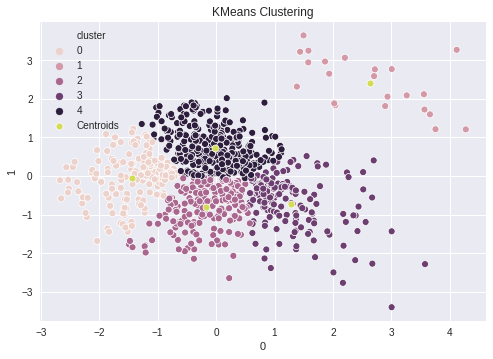

Silhouette Coefficient: 0.3642
Davies Bouldin Index: 0.8318


In [45]:
# Cluster 5, 6 은 큰 차이는 없다.
reduced_scale_df = pd.DataFrame(reduced_scale_df)

km = KMeans(n_clusters=5)
cluster = km.fit(reduced_scale_df)
cluster_id = pd.DataFrame(cluster.labels_)

d1 = pd.concat([reduced_scale_df, cluster_id], axis=1)
d1.columns = [0, 1, "cluster"]

sns.scatterplot(d1[0], d1[1], hue = d1['cluster'], legend="full")
sns.scatterplot(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], label = 'Centroids')
plt.title("KMeans Clustering")
plt.legend()
plt.show()

print('Silhouette Coefficient: {:.4f}'.format(metrics.silhouette_score(d1.iloc[:,:-1], d1['cluster'])))
print('Davies Bouldin Index: {:.4f}'.format(metrics.davies_bouldin_score(d1.iloc[:,:-1], d1['cluster'])))

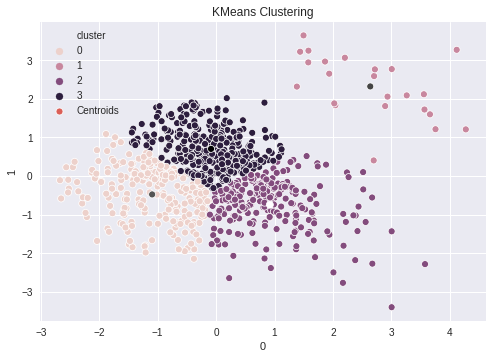

Silhouette Coefficient: 0.3700
Davies Bouldin Index: 0.8305


In [46]:
# Cluster는 나누어지는 것으로 보이나 클러스터 간 거리가 매우 가깝다. 설정한 클러스터 개수에 맞춰서 임의로 나누어진 것일수도 있다.
reduced_scale_df = pd.DataFrame(reduced_scale_df)

km = KMeans(n_clusters=4)
cluster = km.fit(reduced_scale_df)
cluster_id = pd.DataFrame(cluster.labels_)

d1 = pd.concat([reduced_scale_df, cluster_id], axis=1)
d1.columns = [0, 1, "cluster"]

sns.scatterplot(d1[0], d1[1], hue = d1['cluster'], legend="full")
sns.scatterplot(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], label = 'Centroids')
plt.title("KMeans Clustering")
plt.legend()
plt.show()

print('Silhouette Coefficient: {:.4f}'.format(metrics.silhouette_score(d1.iloc[:,:-1], d1['cluster'])))
print('Davies Bouldin Index: {:.4f}'.format(metrics.davies_bouldin_score(d1.iloc[:,:-1], d1['cluster'])))

## 3. DBSCAN

Because the K-means algorithm did not work well due to the form of the data, I applied one of the density-based algorithm DBSCAN that are independent of the form of the data.


디비스캔(DBSCAN: Density-Based Spatial Clustering of Applications with Noise) 은 데이터가 밀집한 정도 즉 밀도를 이용한다. 디비스캔 군집화는 **군집의 형태에 구애받지 않으며** 군집의 갯수를 사용자가 지정할 필요가 없다. 디비스캔 군집화 방법에서는 초기 데이터로부터 근접한 데이터를 찾아나가는 방법으로 군집을 확장한다. 이 때 다음 hyperparameter를 사용한다.
1. 최소거리 eps: 이웃을 정의하기 위한 거리
2. 최소 데이터 갯수 (minimum points): 밀집 지역을 정의하기 위해 필요한 이웃의 개수


**Reduced scaled data**

0.09579616966239089


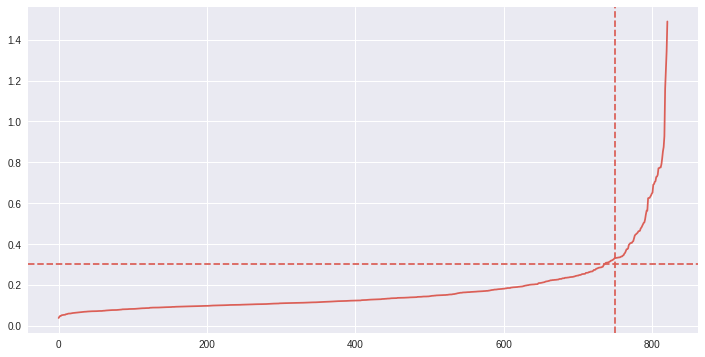

In [47]:
# 각 개체마다 거리를 계산해서 가까운 거리의 5개와 그 떄의 index 반환
neigh = NearestNeighbors(n_neighbors=5)
neigh.fit(reduced_scale_df)
distances, indices = neigh.kneighbors(reduced_scale_df) 

# 4-dist를 plotting 해보기
# 저 빨간점에서 급격히 4-dist가 급증하였다 
# -> 우리는 이 때의 distance인 0.3 부근을 eps로, 4를 minpts로 잡고 DBSCAN을 진행해보도록 하자.
plt.figure(figsize=(12, 6))
plt.plot(np.sort(distances[:, 4]))
plt.axvline(750, 0, 2, ls='--')
plt.axhline(0.3, 0, 200, ls='--')

print(np.sort(distances[:, 4])[188])

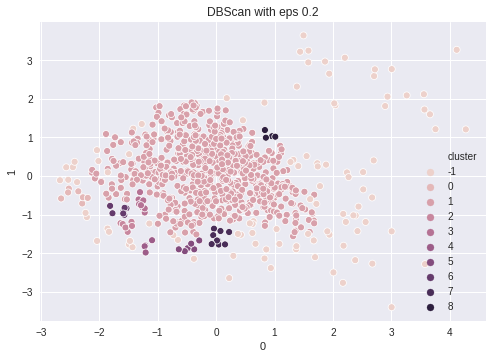

Silhouette Coefficient: -0.1759
Davies Bouldin Index: 1.4477


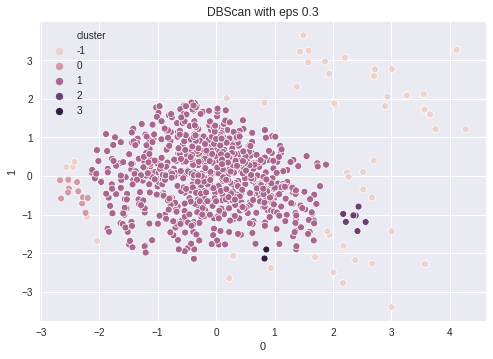

Silhouette Coefficient: 0.1329
Davies Bouldin Index: 1.3496


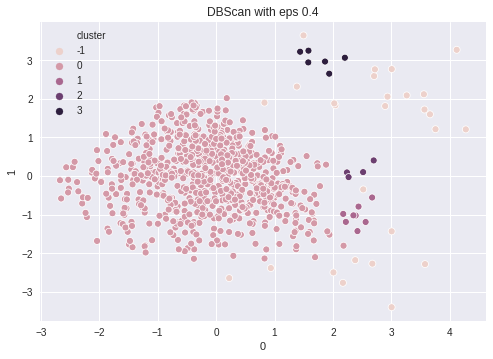

Silhouette Coefficient: 0.3215
Davies Bouldin Index: 3.0499


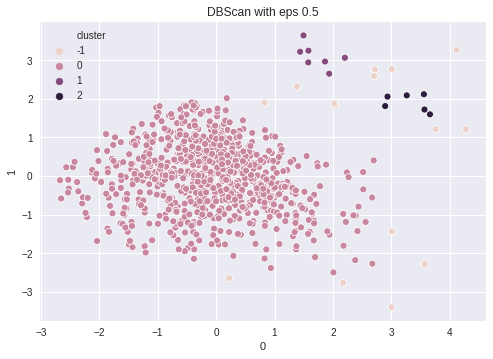

Silhouette Coefficient: 0.5102
Davies Bouldin Index: 1.5207


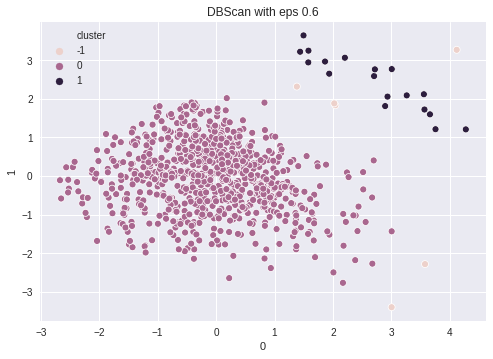

Silhouette Coefficient: 0.5519
Davies Bouldin Index: 1.7123


In [48]:
# eps가 0.6일 때 silhouette score가 0.5519로 K-means 알고리즘을 사용했을 때보다 높은 수치였으나
# plot을 보면 균일하게 군집화되지 않았음을 볼 수 있다.

eps = [0.2, 0.3, 0.4, 0.5, 0.6]
for i in eps:
    db = DBSCAN(eps=i, min_samples=4)
    cluster = db.fit(reduced_scale_df)
    cluster_id = pd.DataFrame(cluster.labels_)
    
    d3 = pd.DataFrame()
    d3 = pd.concat([reduced_scale_df,cluster_id],axis=1)
    d3.columns = [0, 1, "cluster"]
    
    sns.scatterplot(d3[0], d3[1], hue = d3['cluster'], legend="full")
    plt.title('DBScan with eps {}'.format(i))
    plt.show()
    
    print('Silhouette Coefficient: {:.4f}'.format(metrics.silhouette_score(d3.iloc[:,:-1], d3['cluster'])))
    print('Davies Bouldin Index: {:.4f}'.format(metrics.davies_bouldin_score(d3.iloc[:,:-1], d3['cluster'])))

# Evaluation

**Reduced and scaled data**

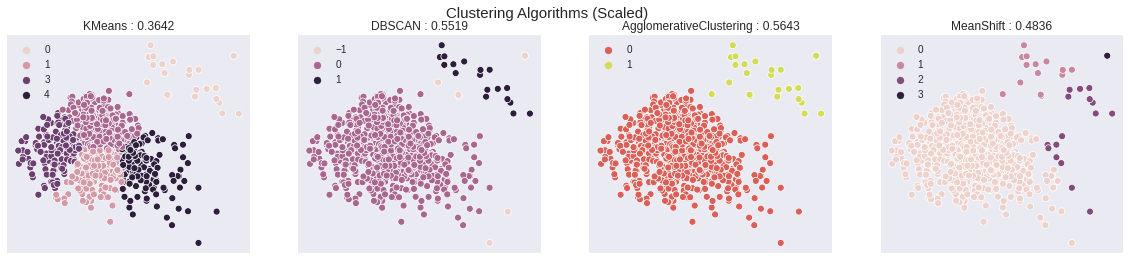

In [49]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 4), subplot_kw={'xticks': (), 'yticks': ()})
fig.suptitle('Clustering Algorithms (Scaled)', fontsize=15)

algorithms = [KMeans(n_clusters=5), 
              DBSCAN(eps=0.6, min_samples=4),
              AgglomerativeClustering(n_clusters=2,linkage='complete'),
              MeanShift(bandwidth=estimate_bandwidth(reduced_scale_df, quantile=0.2, n_samples=100))
              ]

for ax, algorithm in zip(axes.flatten(), algorithms):
    clusters = algorithm.fit_predict(reduced_scale_df)
    sns.scatterplot(reduced_scale_df.loc[:, 0], reduced_scale_df.loc[:, 1], hue=clusters, ax=ax)
    ax.set(title="{} : {:.4f}".format(algorithm.__class__.__name__,
                                      silhouette_score(reduced_scale_df, clusters)))
plt.show()

In [0]:
# 추후에 데이터의 outlier를 제거하거나, 다른 feature를 추가하는 방법으로 데이터의 분포를 다르게 하여 클러스터링을 해볼 수 있을 것으로 기대된다.